In [1]:
# import packages
import numpy as np
from scipy import misc
from scipy import fftpack
from matplotlib import pyplot as plt
import copy

# switch on inline plotting
%matplotlib inline

In [2]:
# choose image path
path = "/home/malte/Bilder/2016-08-11/CIMG6844.JPG"

# load image
f = misc.imread(path, flatten=True)

# get image shape
nx, ny = f.shape # nx..number of px in vertical direction, ny..number of px in horizontal direction
print nx, ny

2176 3264


(2048, 2048)


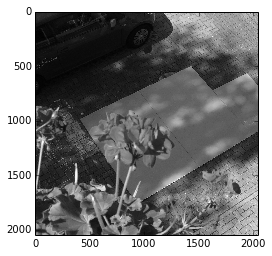

In [3]:
# crop image to power-of-2 shape
snx = 2**np.floor(np.log(nx)/np.log(2))
sny = 2**np.floor(np.log(ny)/np.log(2))
s = f[0:snx, 0:sny]
print s.shape
plt.figure()
plt.imshow(s, interpolation='nearest', cmap=plt.cm.gray)

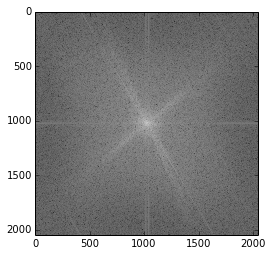

In [4]:
# fourier transform and shift
s_fft = fftpack.fft2(s)
s_fft = fftpack.fftshift(s_fft)
F = np.abs(s_fft)**2
plt.figure()
plt.imshow(np.log(F), interpolation='nearest', cmap=plt.cm.gray)

In [5]:
# test: shift back and fourier transform back
b = fftpack.ifft2(fftpack.ifftshift(s_fft))
#plt.imshow(b.real, interpolation='nearest', cmap=plt.cm.gray)

0.00390625


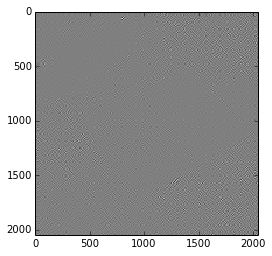

In [6]:
# crop low frequencies in fourier space
px = 64 # half number of pixels to keep in x direction
py = 64 # half number of pixels to keep in y direction
i_highpass = copy.deepcopy(s_fft)
i_highpass[px:snx-px] = 0
i_highpass[0:snx, py:sny-py] = 0
print 1. - (i_highpass == 0).sum() / (snx * sny)
i_highpass = fftpack.ifftshift(i_highpass)
back_highpass = fftpack.ifft2(i_highpass)
plt.figure()
plt.imshow(back_highpass.real, interpolation='nearest', cmap=plt.cm.gray)

0.00390625


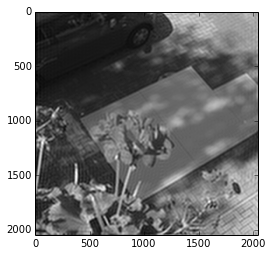

In [7]:
# crop high frequencies in fourier space
px = 64 # half number of pixels to keep in x direction
py = 64 # half number of pixels to keep in y direction
i_lowpass = copy.deepcopy(s_fft)
i_lowpass = fftpack.ifftshift(i_lowpass)
i_lowpass[px:snx-px] = 0
i_lowpass[0:snx, py:sny-py] = 0
back_lowpass = fftpack.ifft2(i_lowpass)
print 1. - (i_lowpass == 0).sum() / (snx * sny)
plt.figure()
plt.imshow(back_lowpass.real, interpolation='nearest', cmap=plt.cm.gray)

0.00390791893005


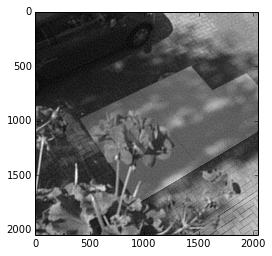

In [8]:
# crop histogram in fourier space
i_histpass = copy.deepcopy(s_fft)
i_histpass = fftpack.ifftshift(i_histpass)
h = np.abs(i_histpass)**2+1
h = np.log(i_histpass)
hm = h.mean()
hm = 0.6291*h.max()
mask = h<hm
print 1. - mask.sum() / (snx*sny)
i_histpass[mask] = 0
back_histpass = fftpack.ifft2(i_histpass)
plt.figure()
plt.imshow(back_histpass.real, interpolation='nearest', cmap=plt.cm.gray)

<matplotlib.colorbar.Colorbar instance at 0x112e4200>

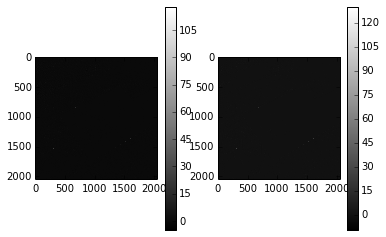

In [9]:
# plot "error" of histpass and highpass
plt.figure()
plt.subplot(1,2,1)
plt.imshow((back_histpass.real-s)/s, interpolation='nearest', cmap=plt.cm.gray)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow((back_lowpass.real-s)/s, interpolation='nearest', cmap=plt.cm.gray)
plt.colorbar()

# Behavior of 1- and 2-norm under FFT

In [65]:
def arr_norm1(a):
    return np.sum(np.abs(a))

def arr_norm2(a):
    return np.sqrt(np.sum(np.abs(a)**2))

def arr_fft_norm1(a):
    return np.sum(np.abs(fftpack.fft2(a)))

def arr_fft_norm2(a):
    return np.sqrt(np.sum(np.abs(fftpack.fft2(a))**2))

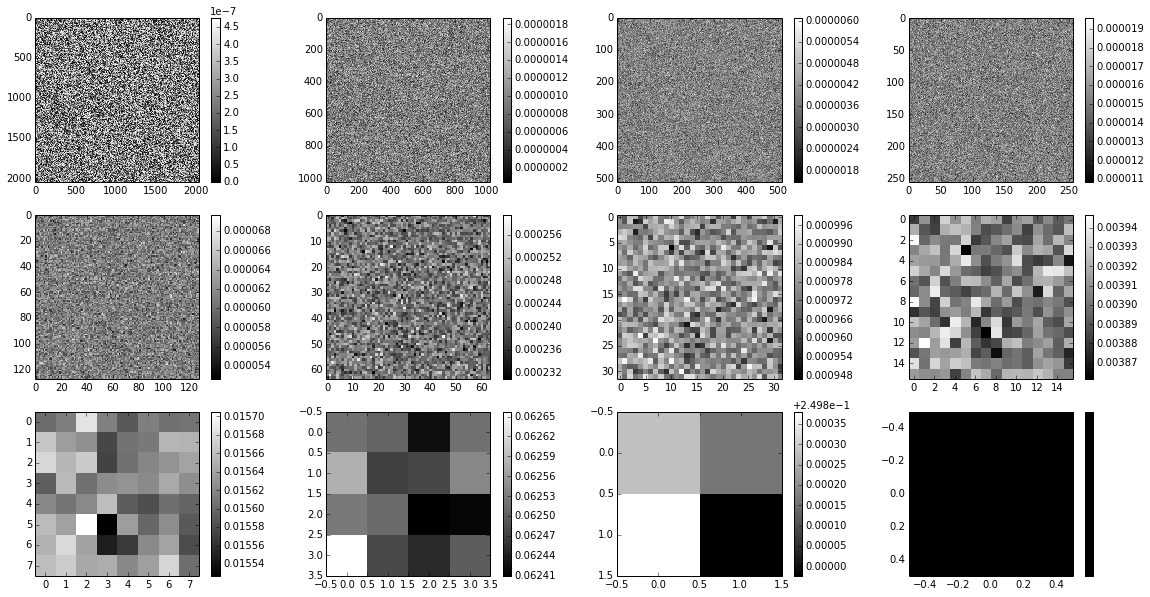

In [66]:
# prepare lists of arrays - for interesting stuff, see next box
import random

def shrink(data, rows, cols):
    return data.reshape(rows, data.shape[0]/rows, cols, data.shape[1]/cols).sum(axis=1).sum(axis=2)

base_res = 2048

a_norm1one = []
a_norm1one.append(np.zeros(shape=(base_res, base_res)))
for i in range(a_norm1one[0].shape[0]):
    for j in range(a_norm1one[0].shape[1]):
        a_norm1one[0][i, j] = random.random()
a_norm1one[0] = a_norm1one[0]/arr_norm1(a_norm1one[0])

res = base_res/2
i = 1
while base_res/2**i >= 1:
    a_norm1one.append(shrink(a_norm1one[i-1], base_res/2**i, base_res/2**i))
    i += 1

fig = plt.figure(figsize=(20,10))
for i in range(3):
    for j in range(4):
        fig.add_subplot(3,4,i*4+j+1)
        plt.imshow(a_norm1one[i*4+j], interpolation='nearest', cmap=plt.cm.gray)
        plt.colorbar()

a_norm2one = []
a_norm2one.append(    a_norm1one[0]/arr_norm2(a_norm1one[0]))
for i in range(len(a_norm1one)):
    a_norm2one.append(a_norm1one[i]/arr_norm2(a_norm1one[i]))
    

In [68]:
# show cumulative properties of arrays and their FFTs
print "a_norm1one:"
print "----------"
for i in range(len(a_norm1one)):
    print "norm1: %f"      %arr_norm1(    a_norm1one[i]), \
          "   norm2: %f"    %arr_norm2(    a_norm1one[i]), \
          "   fft_norm2: %f"%arr_fft_norm2(a_norm1one[i])

print ""
print "a_norm2one:"
print "----------"
for i in range(len(a_norm2one)):
    print "norm1: %f"      %arr_norm1(    a_norm2one[i]), \
          "   norm2: %f"    %arr_norm2(    a_norm2one[i]), \
          "   fft_norm2: %f"%arr_fft_norm2(a_norm2one[i])


a_norm1one:
----------
norm1: 1.000000    norm2: 0.000564    fft_norm2: 1.154793
norm1: 1.000000    norm2: 0.001016    fft_norm2: 1.040882
norm1: 1.000000    norm2: 0.001973    fft_norm2: 1.010367
norm1: 1.000000    norm2: 0.003916    fft_norm2: 1.002617
norm1: 1.000000    norm2: 0.007818    fft_norm2: 1.000655
norm1: 1.000000    norm2: 0.015628    fft_norm2: 1.000164
norm1: 1.000000    norm2: 0.031251    fft_norm2: 1.000042
norm1: 1.000000    norm2: 0.062501    fft_norm2: 1.000010
norm1: 1.000000    norm2: 0.125000    fft_norm2: 1.000002
norm1: 1.000000    norm2: 0.250000    fft_norm2: 1.000000
norm1: 1.000000    norm2: 0.500000    fft_norm2: 1.000000
norm1: 1.000000    norm2: 1.000000    fft_norm2: 1.000000

a_norm2one:
----------
norm1: 1773.478378    norm2: 1.000000    fft_norm2: 2048.000000
norm1: 1773.478378    norm2: 1.000000    fft_norm2: 2048.000000
norm1: 983.780808    norm2: 1.000000    fft_norm2: 1024.000000
norm1: 506.746458    norm2: 1.000000    fft_norm2: 512.000000
norm